In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pickle

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import cifar10

# import parameters
#from model_params import *


Using TensorFlow backend.


In [2]:
img_rows, img_cols, img_chns = 92, 92, 3
latent_dim = 20
intermediate_dim = 512
epsilon_std = 1.0
epochs = 15
filters = 60
num_conv = 3
batch_size = 20

../img/Fall/cacharel/10.jpg


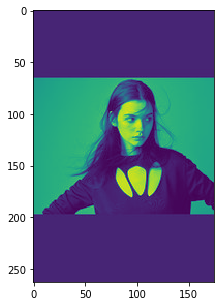

../img/Fall/a-w-a-k-e-/7.jpg


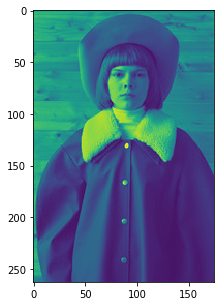

../img/Fall/a-w-a-k-e-/17.jpg


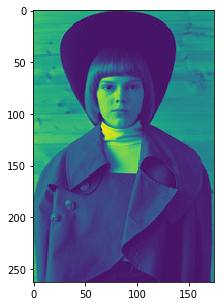

../img/Fall/a-w-a-k-e-/53.jpg


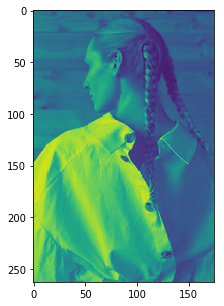

../img/Fall/a-w-a-k-e-/52.jpg


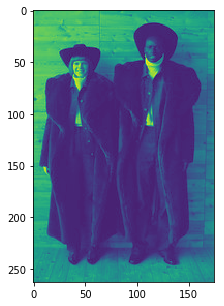

../img/Fall/a-w-a-k-e-/30.jpg


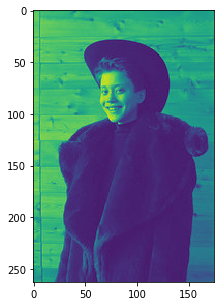

../img/Fall/a-w-a-k-e-/68.jpg


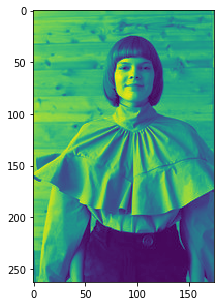

../img/Fall/a-w-a-k-e-/4.jpg


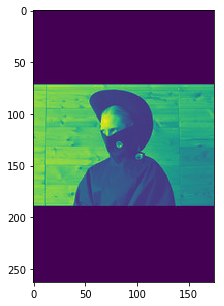

../img/Fall/a-w-a-k-e-/38.jpg


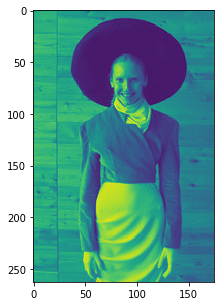

../img/Fall/a-w-a-k-e-/64.jpg


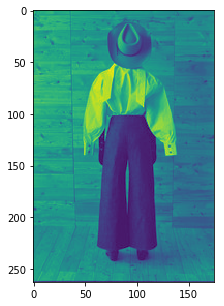

../img/Fall/a-w-a-k-e-/79.jpg


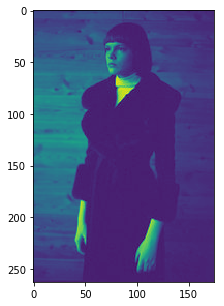

../img/Fall/a-w-a-k-e-/56.jpg


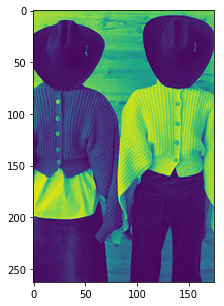

../img/Fall/a-w-a-k-e-#collection/7.jpg


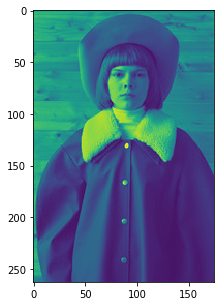

../img/Fall/a-w-a-k-e-#collection/17.jpg


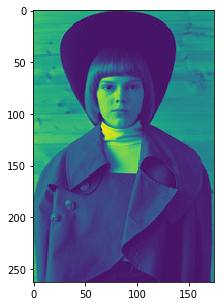

../img/Fall/a-w-a-k-e-#collection/30.jpg


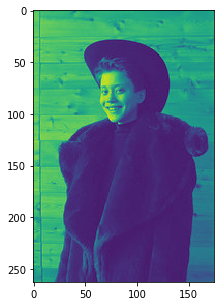

../img/Fall/a-w-a-k-e-#collection/4.jpg


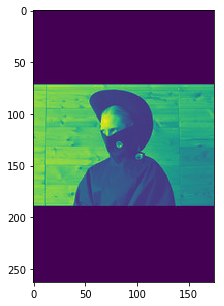

../img/Fall/a-w-a-k-e-#collection/38.jpg


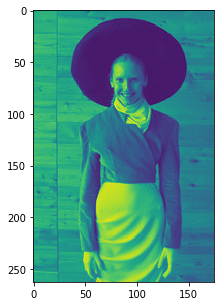

Input size (3867, 92, 92, 3)
(92, 92, 3)
(3093, 92, 92, 3)


In [3]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split

show_name = "Fall"
src_dir = "../img/%s" % show_name

input_files = []
for root, dirs, files in os.walk(src_dir):
    for f in files:
        if os.path.splitext(f)[-1].lower() in [".jpg", ".JPG"]:
            os.path.join(root, f)
            input_files.append(os.path.join(root, f))
            
#input_files = [os.path.join(src_dir, f) for f in os.listdir(src_dir) if f.endswith(".jpg")]
#imgs = [Image.open(im).convert('RGB').resize((172, 260), Image.ANTIALIAS) for im in input_files]
#lwf_immatrix = np.array([np.array(im) for im in imgs])

lwf_immatrix = []
for im in input_files:
    img = Image.open(im)
    if len(np.array(img).shape) != 3:
        print(im)
        plt.figure(figsize=(5, 5))
        plt.imshow(np.array(img))
        plt.show()
    else:
        #lwf_immatrix.append(np.array(img.resize((172, 260), Image.ANTIALIAS)))
        lwf_immatrix.append(np.array(img.resize((img_rows, img_cols), Image.ANTIALIAS))) # change in img_row! in the above cell

lwf_immatrix = np.array(lwf_immatrix)
        
    
#lwf_immatrix = np.array([np.array(Image.open(im)) for im in input_files])
print("Input size", lwf_immatrix.shape)

#plt.figure(figsize=(5, 5))
#plt.imshow(lwf_immatrix[0])
#plt.show()

x_train, x_test, _, _ = train_test_split(lwf_immatrix, [0]*len(lwf_immatrix), test_size=0.20, random_state=42)

original_img_size = lwf_immatrix[0].shape

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
print(original_img_size)
print(x_train.shape)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

In [4]:
# tensorflow uses channels_last
# theano uses channels_first
"""
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
"""
#original_img_size = (img_rows, img_cols, img_chns)

# encoder architecture
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

# mean and variance for latent variables
z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


# decoder architecture
decoder_hid = Dense(intermediate_dim, activation='relu')


decoder_upsample = Dense(int(filters * round(img_rows / 2) * round(img_cols / 2)), activation='relu')
output_shape = (batch_size, int(round(img_rows / 2)), int(round(img_cols / 2)), filters)

"""
decoder_upsample = Dense(16 * 16 * filters, activation='relu')
output_shape = (batch_size, 16, 16, filters)
"""

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        print(x)
        print(x_decoded_mean_squash)
        loss = self.vae_loss(x, x_decoded_mean_squash)
        print(loss)
        self.add_loss(loss, inputs=inputs)
        return x



def my_vae_loss(x, x_decoded_mean_squash):
    x = K.flatten(x)
    x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
    xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

vae = Model(x, x_decoded_mean_squash)
vae.compile(optimizer='Adam', loss=my_vae_loss)

# entire model
#y = CustomVariationalLayer()([x, x_decoded_mean_squash])
#vae = Model(x, y)
#vae.compile(optimizer='Adam', loss=None)
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 92, 92, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 92, 92, 3)    39          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 46, 46, 60)   780         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 46, 46, 60)   32460       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [5]:
# training
history = vae.fit(x_train,
                  x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=30,
        validation_data=(x_test, x_test))

# encoder from learned model
encoder = Model(x, z_mean)

# generator / decoder from learned model
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

# save all 3 models for future use - especially generator
vae.save('../models/cifar10_%d*%d_ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (img_rows, img_cols, latent_dim, num_conv, intermediate_dim, epochs))
encoder.save('../models/cifar10_%d*%d_ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (img_rows, img_cols, latent_dim, num_conv, intermediate_dim, epochs))
generator.save('../models/cifar10_%d*%d_ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (img_rows, img_cols, latent_dim, num_conv, intermediate_dim, epochs))

# save training history
fname = '../models/cifar10_ld_%d*%d_%d_conv_%d_id_%d_e_%d_history.pkl' % (img_rows, img_cols, latent_dim, num_conv, intermediate_dim, epochs)
with open(fname, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 3093 samples, validate on 774 samples
Epoch 1/15
3093/3093 [==============================] - 532s 172ms/step - loss: 5925.0714 - val_loss: 5797.0345
Epoch 2/15
3093/3093 [==============================] - 521s 169ms/step - loss: 5485.4892 - val_loss: 5092.4125
Epoch 3/15
3093/3093 [==============================] - 530s 171ms/step - loss: 4946.2911 - val_loss: 4900.9567
Epoch 4/15
3093/3093 [==============================] - 527s 170ms/step - loss: 4784.7913 - val_loss: 4778.4417
Epoch 5/15
3093/3093 [==============================] - 528s 171ms/step - loss: 4695.9838 - val_loss: 4730.5622
Epoch 6/15
3093/3093 [==============================] - 524s 169ms/step - loss: 4659.0022 - val_loss: 4694.2726
Epoch 7/15
3093/3093 [==============================] - 523s 169ms/step - loss: 4622.9167 - val_loss: 4671.9702
Epoch 8/15
3093/3093 [==============================] - 522s 169ms/step - loss: 4593.6652 - val_loss: 4696.7166
Epoch 9/15
3093/3093 [==============================] - 5

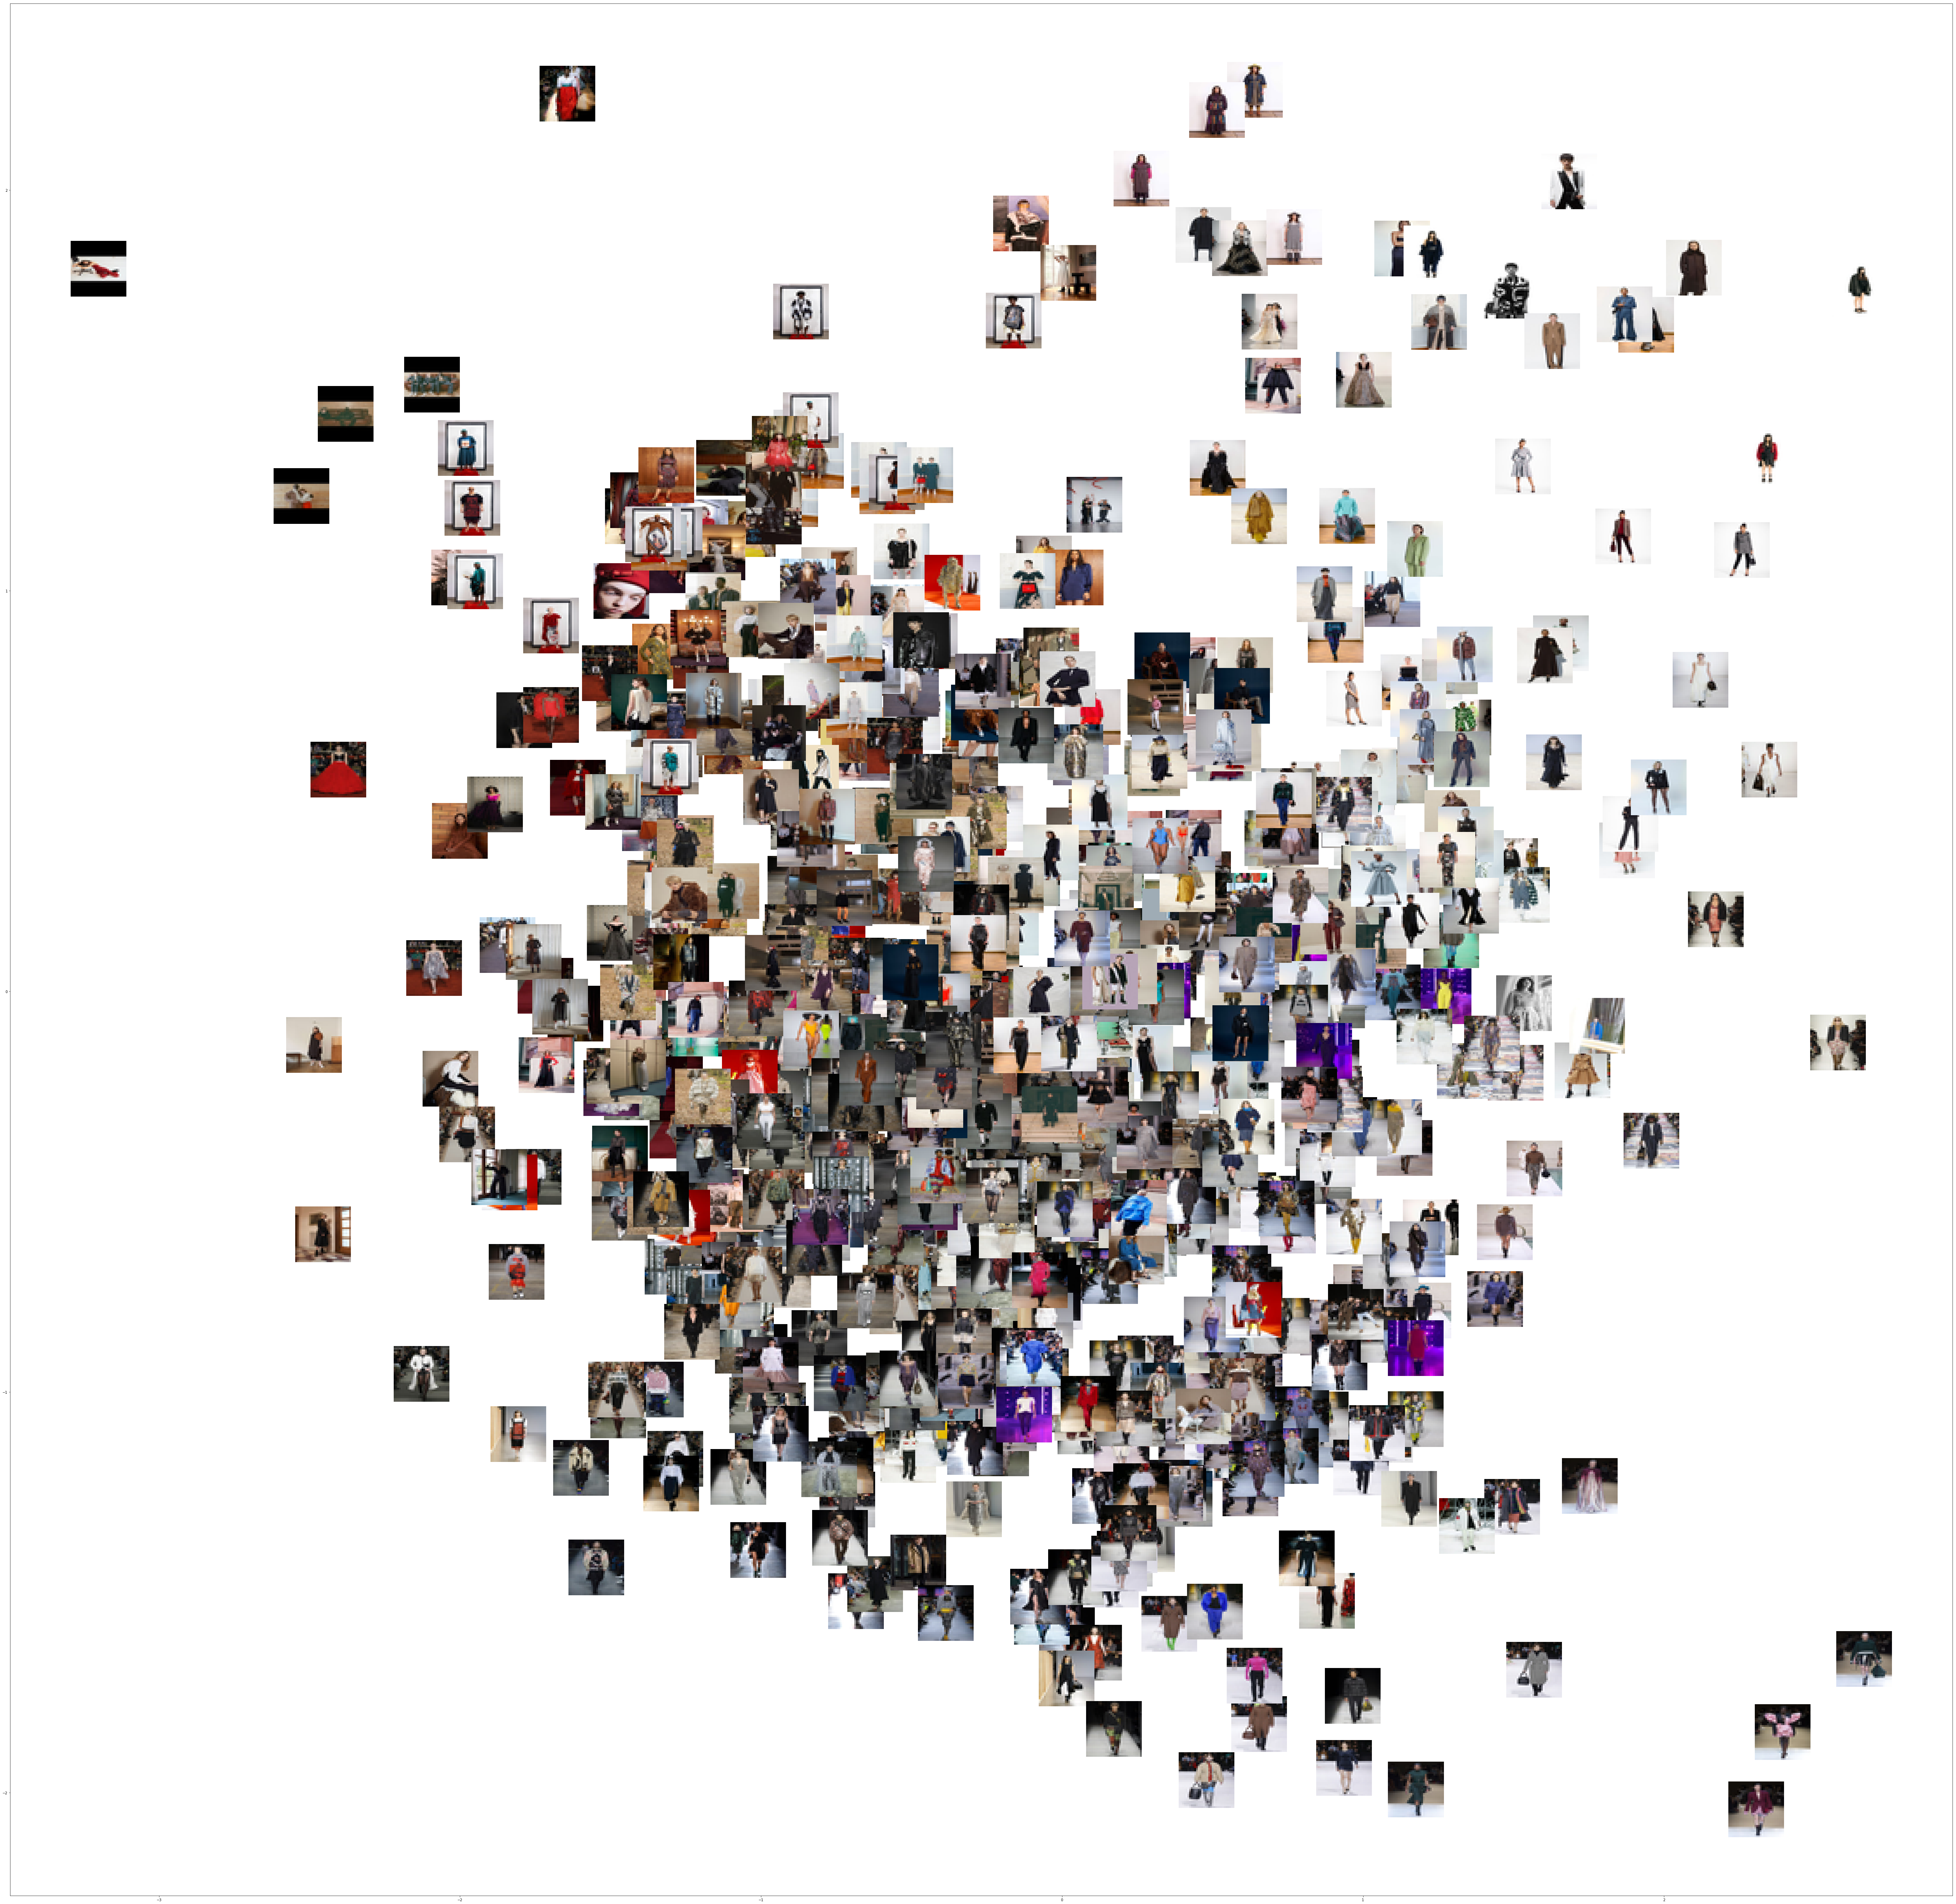

In [14]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


def getImage(img,zoom=5):
    return OffsetImage(img,zoom=zoom)

imgs = x_test
x = x_test_encoded[:, 0]
y = x_test_encoded[:, 1]

fig, ax = plt.subplots(figsize=(100, 100))
ax.scatter(x, y) 

artists = []
for x0, y0, img in zip(x, y, imgs):
    ab = AnnotationBbox(getImage(img), (x0, y0), frameon=False)
    artists.append(ax.add_artist(ab))

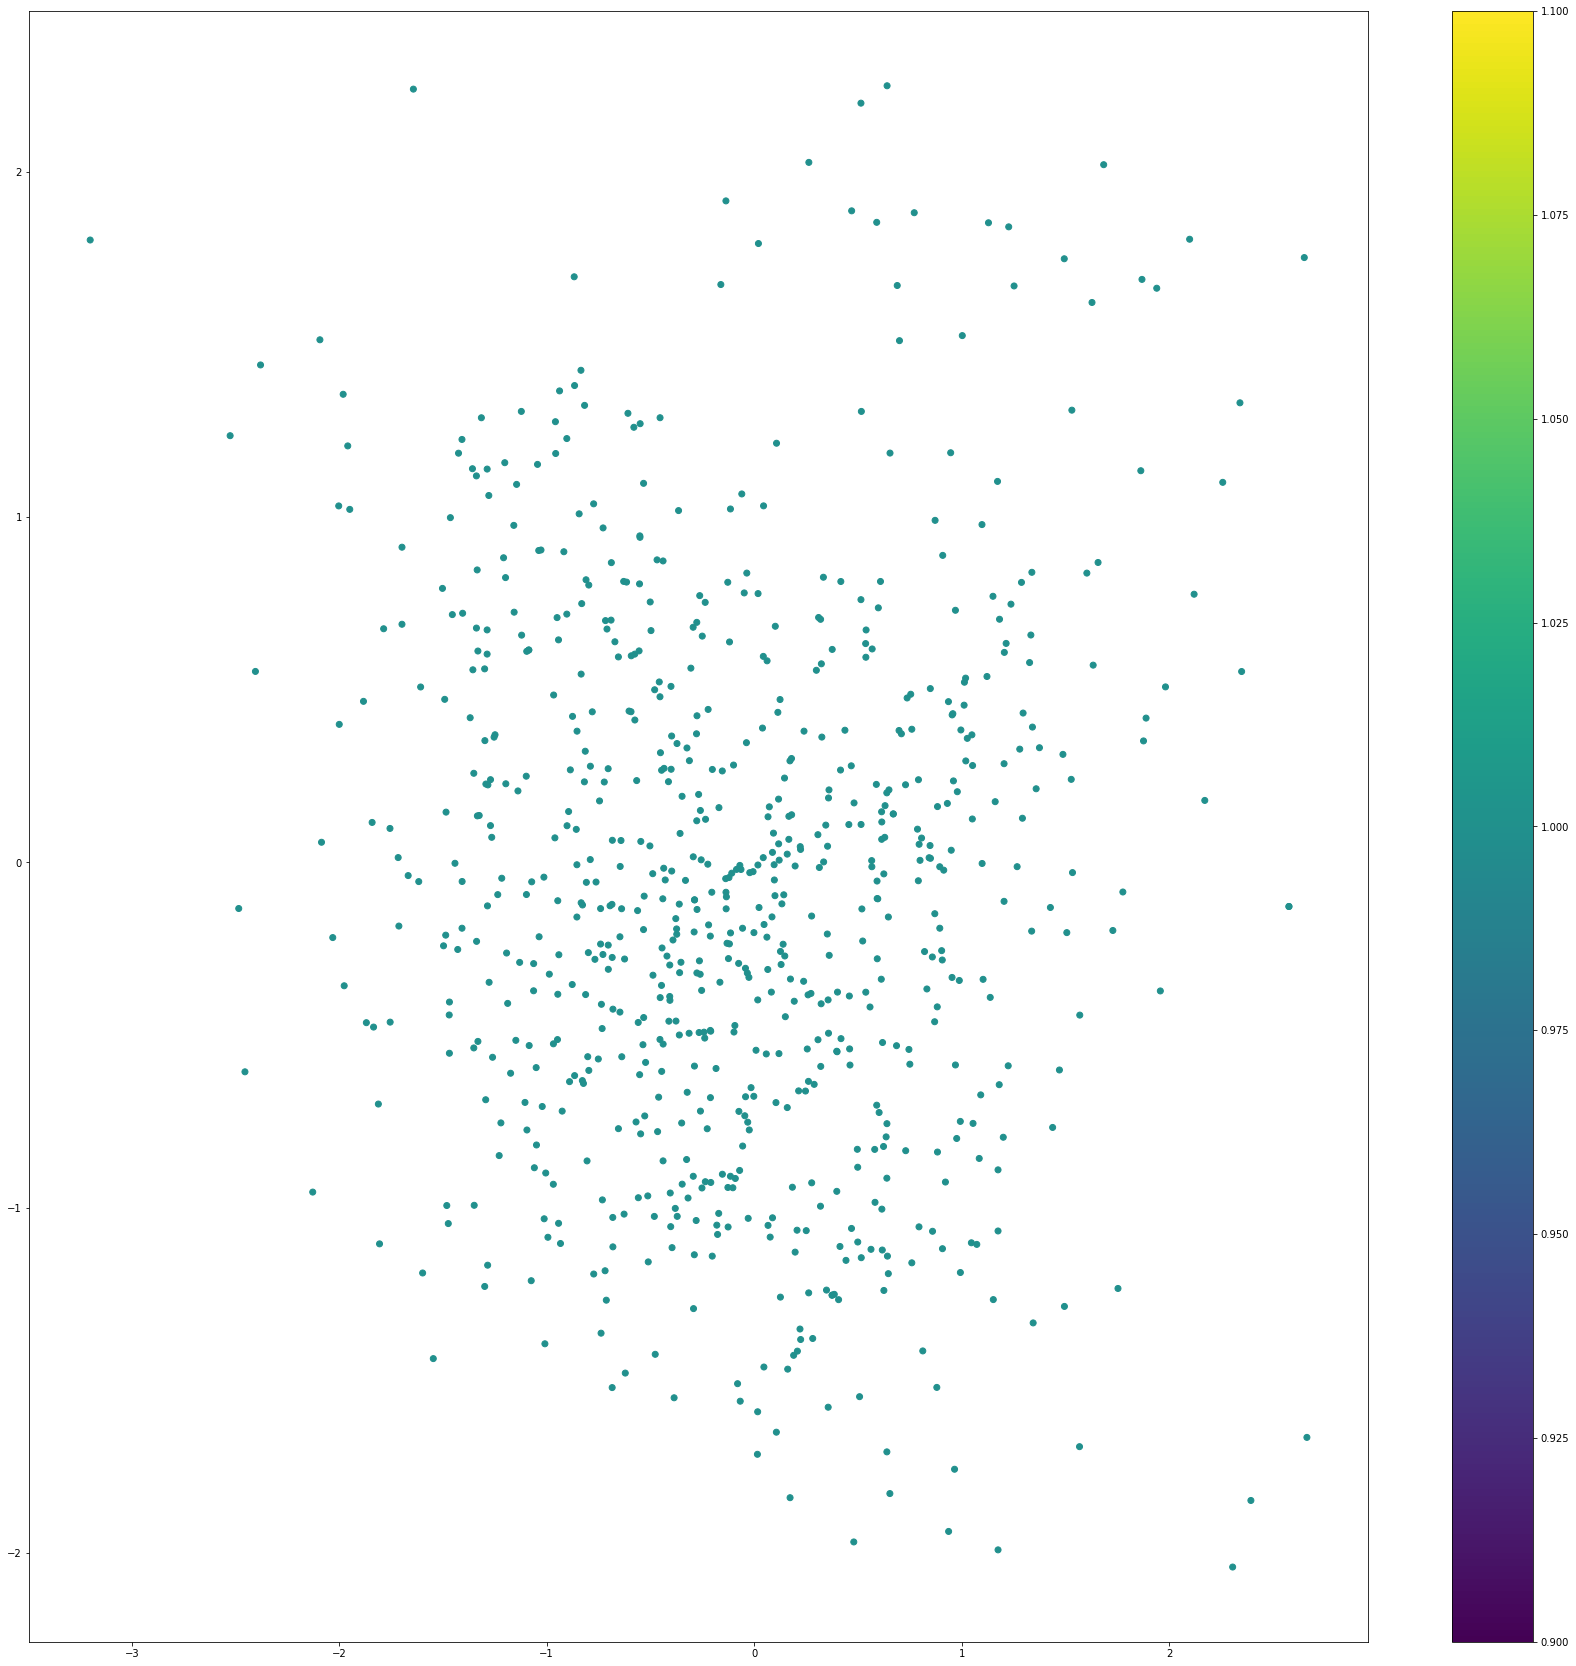

In [8]:
# display a 2D plot of the classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(30, 30))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=[1]*len(x_test))
plt.colorbar()
plt.show()

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import keras
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import cifar10
import pickle

if latent_dim == 3:
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1],x_test_encoded[:, 2], c=y_test)
    plt.show()

if latent_dim == 2:
    # display a 2D plot of the classes in the latent space
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=[1]*len(x_test))
    plt.colorbar()
    plt.show()

    

[[-0.18898957  0.14756756 -0.09693829 -0.65225085 -0.91758511  0.50672926
   0.88325284 -0.43186087  0.10662691  0.36506308 -0.11102583  0.78574985
  -0.50615865 -0.51110949 -0.12706317  0.24846632  0.6089255   0.29250357
   0.4629818   0.04759298]] 1


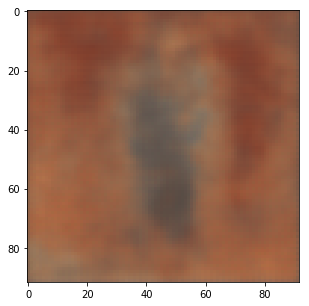

[[-0.53742442  0.14984813 -0.47562641  0.55603058 -0.96076172  0.71026979
  -0.89342879  0.77255739  0.45791797 -0.0901121  -0.29934096 -0.25387717
   0.26934584 -0.48477855 -0.68591475  0.28408116 -0.42480948 -0.26540059
   0.02124956 -0.63070035]] 1


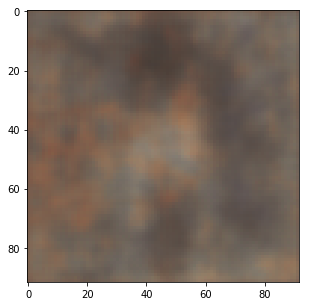

[[ 0.60248759  0.88290829  0.0532363  -0.21092007 -0.27975253  0.26779272
   0.09038977 -0.84845821  0.07856153  0.00562469  0.90237184 -0.61307143
  -0.03759817  0.90545288  0.9810361   0.48675378 -0.31798245 -0.63872727
   0.4416629   0.75738463]] 1


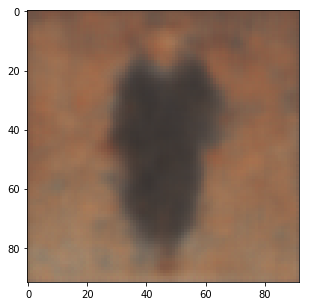

[[-0.26479315 -0.15753646 -0.10395997 -0.21991321  0.61823421 -0.75880004
  -0.12066192  0.39240364 -0.59860621 -0.47116236 -0.23862303 -0.72746283
  -0.79671738 -0.52424684  0.59193849 -0.42507253  0.4488138   0.02609375
   0.71109911  0.28636782]] 1


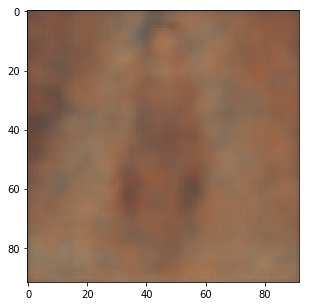

[[ 0.10979204 -0.30171283 -0.13456847  0.38257004 -0.79554524  0.65694663
  -0.91286347 -0.18995942 -0.78712835 -0.59141994  0.23012292  0.90862025
  -0.88037666  0.76789523  0.00117495  0.31101178 -0.9489963   0.1737495
  -0.84335901  0.73099131]] 1


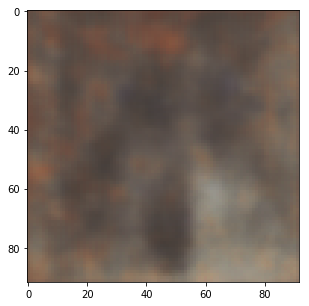

[[-0.12270898  0.39319981 -0.9388922  -0.45510211 -0.69451928  0.6125065
  -0.98484979 -0.13753692 -0.99642925  0.60657885 -0.80008421  0.96032912
   0.63649133  0.68511409 -0.41337873  0.523308   -0.20321734 -0.94979634
  -0.48223337  0.49470382]] 1


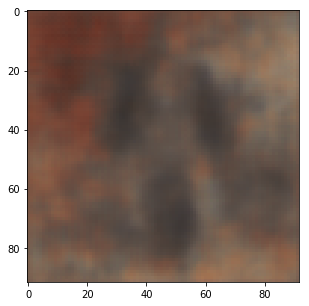

[[ 0.8907957  -0.72075401  0.49298643 -0.0865727  -0.7713009   0.24586652
   0.90622778 -0.04484339 -0.63686284  0.73464114 -0.01509181 -0.4744644
  -0.26023499 -0.27821458 -0.71584449 -0.12213357 -0.51235441 -0.68297512
   0.00521143 -0.9492188 ]] 1


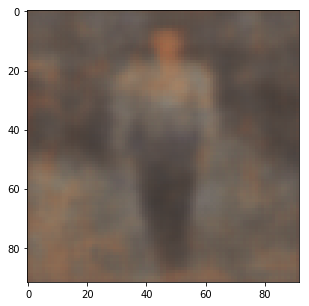

[[ 0.19713166  0.40246167 -0.57558499 -0.53730967  0.51943492  0.35736229
  -0.97408727 -0.50892735  0.91197523 -0.07014226  0.51770313  0.89488808
  -0.99581617  0.22055121 -0.11451093 -0.1405677   0.99976916  0.79751056
   0.87919196  0.11148007]] 1


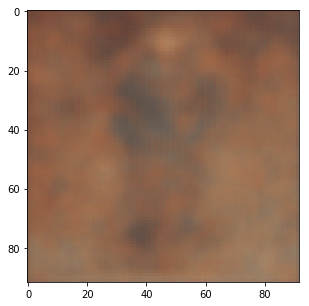

[[ 0.70265711 -0.70086852  0.52930568 -0.70106212  0.30093795  0.22538162
   0.94732287  0.37799698 -0.25915366  0.81973435 -0.65676768 -0.52513462
   0.67048618 -0.3242691  -0.10277     0.4296467  -0.18249855  0.71364886
  -0.81226449  0.2903106 ]] 1


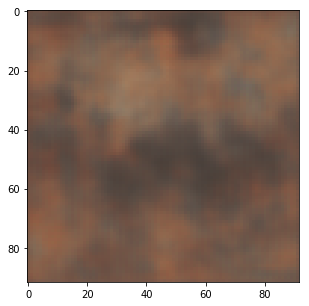

[[ 0.82810969 -0.80128056  0.18107016  0.4999872  -0.94766635 -0.66458733
  -0.9385092  -0.25541049 -0.66310235 -0.6974335  -0.08764616 -0.74946816
  -0.12109447  0.75766517  0.32634959  0.91960868 -0.30305627  0.21698534
  -0.40459255  0.20333129]] 1


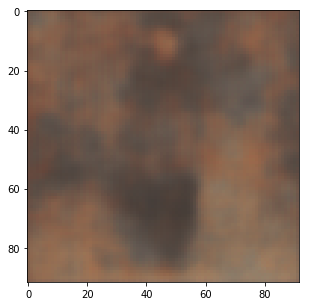

[[ 0.53032587 -0.51253224 -0.82193331  0.89912659 -0.48955479 -0.07141888
  -0.30088157 -0.3411311   0.7355862  -0.3832777   0.73483054  0.07414438
   0.97110087 -0.87258513  0.34476842  0.63095059  0.83021653 -0.46527198
   0.55166804 -0.10648835]] 1


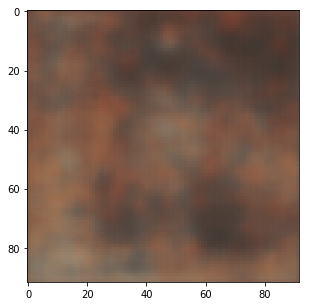

[[ 0.5084893   0.14579008 -0.17533338 -0.79893174  0.87488569 -0.71280971
  -0.7003478  -0.19774766 -0.87192787  0.55224521  0.75073333 -0.05531594
   0.47306603 -0.11010973  0.47140394 -0.74387619 -0.24270117 -0.06807055
   0.54166372 -0.21739775]] 1


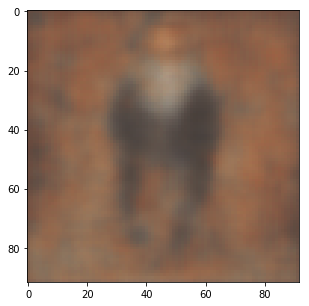

[[ 0.28350938  0.21971825  0.47645229  0.03790144 -0.77450608  0.08998566
  -0.00732138  0.69488793  0.11451147 -0.86816091  0.48629369  0.57766114
  -0.72114739  0.95696976  0.5055721  -0.64600434  0.67561255  0.86346571
   0.39006775  0.75346897]] 1


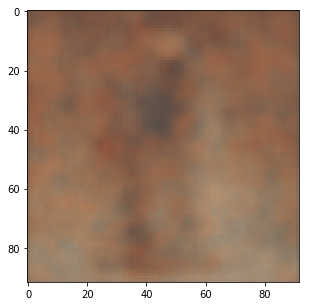

[[-0.25953261 -0.42342405 -0.03761674  0.8288793   0.78843383 -0.44579512
  -0.26354638  0.59923638  0.14791293  0.7014853  -0.2273148   0.98969519
  -0.94869181  0.25574652 -0.18597895 -0.88493642  0.17754195 -0.33378713
  -0.85038652  0.71065331]] 1


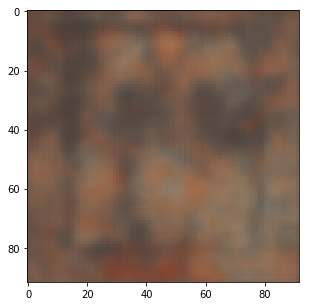

[[ 0.65025535  0.23023812  0.42693917  0.18556069  0.03381354 -0.7323289
   0.62232309  0.76104509 -0.30092483  0.10458157 -0.3177656   0.21945098
  -0.81030339  0.13780032  0.23770262  0.88627283  0.11461588  0.20741057
   0.81416713  0.04495547]] 1


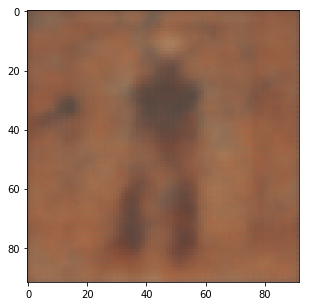

[[-0.68708729 -0.51523286  0.041565   -0.28833337 -0.4705149  -0.87065645
  -0.8663103  -0.95171754  0.57519497 -0.18250871 -0.1655966  -0.54572479
  -0.10655668 -0.84985298 -0.64772075  0.38190657 -0.22847177 -0.05482869
   0.82705906 -0.76175081]] 1


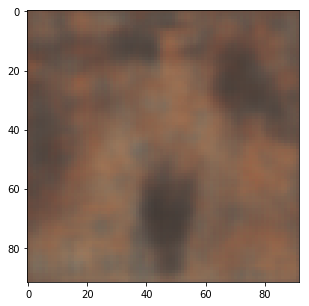

[[-0.06605264  0.55997884 -0.97999947 -0.67514697 -0.6144111  -0.26217158
   0.65814231  0.75909583 -0.43606388  0.16400975 -0.8783048   0.73162275
   0.19826312 -0.91579492 -0.67113717  0.18426232 -0.0890556   0.38012979
  -0.89120057 -0.83074099]] 1


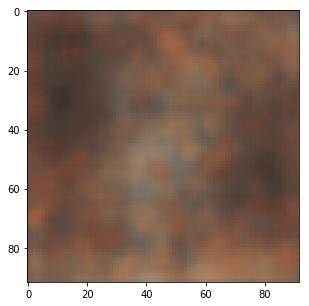

[[ 0.29055429  0.42938482 -0.41020647  0.63886978 -0.76553464 -0.04199049
  -0.36851099  0.0442668   0.94804858  0.4412806   0.7835904  -0.76565066
  -0.13720567  0.69420297 -0.71584102  0.20976824 -0.89719587  0.96029793
  -0.58072605  0.95484784]] 1


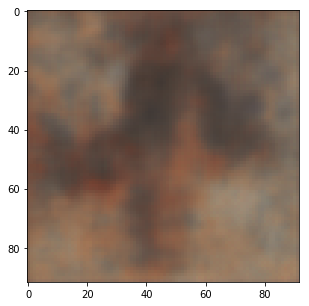

[[ 0.55819927  0.92450001  0.90857695 -0.44726984 -0.19827577  0.16401698
  -0.84548986  0.1903734   0.14022058 -0.51700079 -0.68462084  0.99778509
   0.50487516 -0.81299412 -0.70135463 -0.29406136  0.78903612 -0.28589715
   0.67430362  0.88387378]] 1


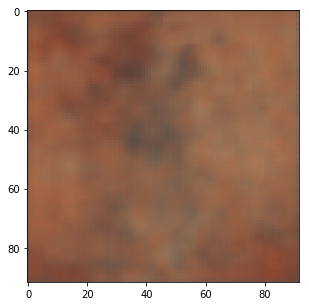

[[-0.32783832 -0.281274   -0.13964427 -0.41172581  0.08421339 -0.993636
  -0.10682745 -0.62382754 -0.50658521  0.35916204  0.40486646 -0.75583748
  -0.2949201   0.94013207 -0.22158963 -0.61634792  0.42308586 -0.08170368
  -0.27918859 -0.40756491]] 1


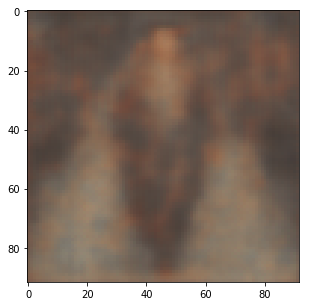

[[-0.72468137 -0.27354972 -0.4946125  -0.33003304 -0.77277594 -0.54156355
  -0.83728458  0.04872735  0.42778463 -0.99377793  0.17576207 -0.26114011
   0.88784056  0.66589826  0.75585212 -0.78600312  0.31066451  0.04167272
   0.30809158  0.38765443]] 1


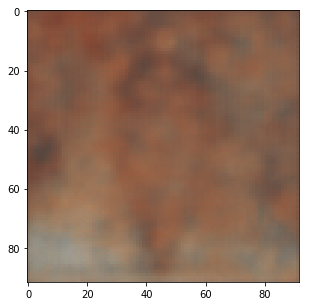

[[ 0.95657547 -0.7513431   0.72062276  0.81113631  0.37612489  0.62292174
   0.03814237 -0.854301   -0.70449823 -0.80334414 -0.32122871  0.36214291
   0.97456216 -0.22500827  0.25725464  0.42895342 -0.53245569 -0.31334079
   0.50958314 -0.76443126]] 1


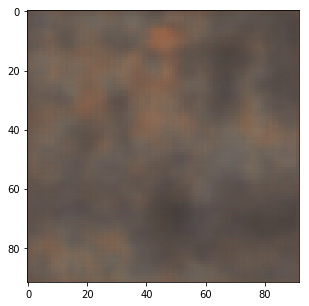

[[-0.0556008   0.04505117 -0.40660147  0.29002581 -0.27685419  0.95300275
   0.92176336 -0.6578705   0.5171606  -0.13355747  0.06206206  0.35163092
  -0.31729386  0.76086986  0.01180017  0.9024947   0.79080145  0.03673347
   0.87947107  0.16476475]] 1


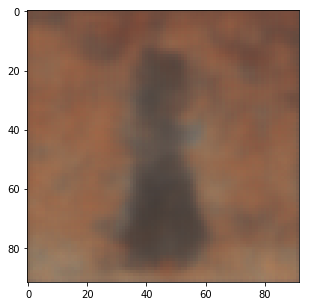

[[ 0.94782694 -0.19705921  0.70385031  0.99626417 -0.01761341  0.3022743
   0.79669263  0.1954284  -0.45178684 -0.89191773 -0.98689817  0.92617285
  -0.66770488  0.02511588 -0.12790758 -0.74909757  0.1860806  -0.92029504
   0.25744008  0.57096247]] 1


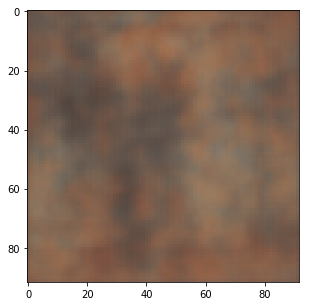

[[-0.8049919  -0.76674374 -0.54948629 -0.13109469 -0.62338554  0.36430063
   0.07185824  0.88858437  0.89418656  0.53405406  0.24755593  0.25244044
   0.61485392 -0.47700045 -0.54012205 -0.94840452  0.09302685  0.71551145
  -0.50534214  0.06017845]] 1


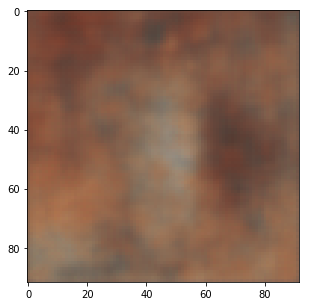

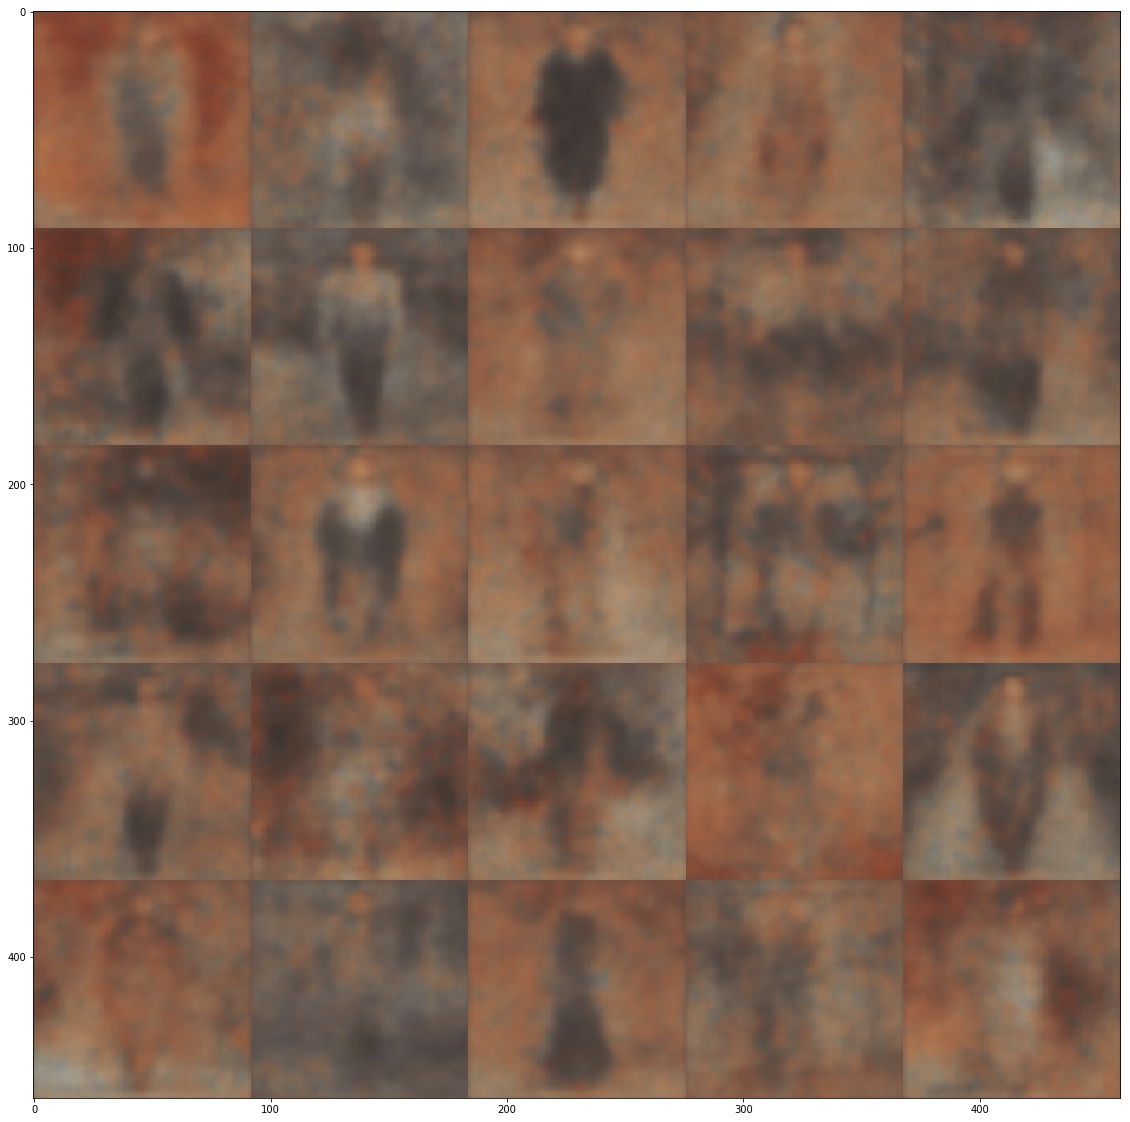

In [6]:
# display images generated from randomly sampled latent vector
n = 5
figure = np.zeros((img_cols * n, img_rows * n, img_chns))


for i in range(n):
    for j in range(n):
        #z_sample = [1] * (latent_dim-1)
        #z_sample.extend([-1])
        #z_sample = np.array([z_sample])
        z_sample = np.array([np.random.uniform(-1,1,size=latent_dim)])
        print(z_sample, len(z_sample))
        x_decoded = generator.predict(z_sample)
        img = x_decoded[0].reshape(img_cols, img_rows, img_chns)
        #print(img)
        figure[i * img_cols: (i + 1) * img_cols, j * img_rows: (j + 1) * img_rows] = img

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.show()


plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
#plt.imshow(figure)
#plt.show()